In [1]:
import ROOT
import math
import numpy as np
#import numpy.linalg as la
import root_numpy as rumpy
from pprint import pprint
from prettytable import PrettyTable
ROOT.RooMsgService.instance().setGlobalKillBelow(5)

Welcome to JupyROOT 6.10/06


## Core Histogramming Functions

In [2]:
def randomise_data(hist,sigma):
    perbin = lambda mu: np.random.normal(mu,sigma/math.sqrt(mu))
    randomised = np.vectorize(perbin)
    return randomised(hist)

In [3]:
def build_array(n_bins = 10, n_events = 100, signal=False):
    if signal:
        slope = np.arange(1,n_bins+1,dtype=float)
        return np.divide(slope,np.sum(slope))*n_events
    else:
        return np.divide(np.ones(n_bins),n_bins)*n_events

In [4]:
def gen_nps(n_nps):
    return np.random.choice(np.linspace(-2,2,201),n_nps)

In [5]:
def make_variations(hist, slope):
    if len(hist) == 1:
        hist[0] = 1
    thebins = np.arange(len(hist))
    if slope < 0:
        thebins = thebins[::-1]
    gradient = lambda b, s: b*s
    sloped = np.vectorize(gradient)
    slope = math.fabs(slope)
    slope_vec = 1.+sloped(thebins, slope)
    p_sloped = np.divide(slope_vec,np.sum(slope_vec))
    n = np.sum(hist) 
    factor = 1./math.sqrt(n)
    ep_sloped = n*p_sloped*factor
    array_up = hist + ep_sloped
    array_down = hist - ep_sloped
    return array_up, array_down

# First make table.

Dictionary of channels, each of which has a number of events and a dictionary of samples each of which has a number of events. 

In [6]:
nominal = build_array(n_bins=2,n_events=100, signal=False)
print 'nominal is', nominal
up, down = make_variations(nominal, -.5)
print 'up is ',up
print 
print 'down is',down

nominal is [ 50.  50.]
up is  [ 56.  54.]

down is [ 44.  46.]


In [7]:
nps= {
    'group0':gen_nps(3),
    'group1':gen_nps(5),
    'group2':gen_nps(10)
}

scheme = {
    'channel0':{
        'n_bins':10,
        'sample0':{
            'signal':True,
            'n_events':100,
            'hist':build_array(n_bins=10,n_events=100, signal=True)
        },
        'sample1':{
            'signal':False,
            'n_events':1000,
            'hist':build_array(n_bins=10,n_events=1000, signal=False),
        }
    },
    'channel1':{
        'n_bins':1,
        'sample0':{
            'signal':True,
            'n_events':10,
            'hist':build_array(n_bins=1,n_events=100, signal=True)
        },
        'sample1':{
            'signal':False,
            'n_events':500,
            'hist':build_array(n_bins=1,n_events=500, signal=False)
        },
        'sample2':{
            'signal':False,
            'n_events':500,
            'hist':build_array(n_bins=1,n_events=500, signal=False)
        }
    }    
}

In [8]:
for i in range(len(scheme)):
    #remove one entry for nps
    x = PrettyTable()
    x.field_names = ["Channel","sample","n bins","n events","signal?"]
    channelname = 'channel{}'.format(i)
    for j in scheme[channelname]:
        if 'sample' in j:
            x.add_row([channelname,j,scheme[channelname]['n_bins'],scheme[channelname][j]['n_events'],scheme[channelname][j]['signal']])
    print x

+----------+---------+--------+----------+---------+
| Channel  |  sample | n bins | n events | signal? |
+----------+---------+--------+----------+---------+
| channel0 | sample1 |   10   |   1000   |  False  |
| channel0 | sample0 |   10   |   100    |   True  |
+----------+---------+--------+----------+---------+
+----------+---------+--------+----------+---------+
| Channel  |  sample | n bins | n events | signal? |
+----------+---------+--------+----------+---------+
| channel1 | sample1 |   1    |   500    |  False  |
| channel1 | sample0 |   1    |    10    |   True  |
| channel1 | sample2 |   1    |   500    |  False  |
+----------+---------+--------+----------+---------+


## Avoid massive dictionaries. Move to classes instead

In [9]:
class Model(object):
    def __init__(self):
        self.n_channels = 0
        self.channels = {}
        
        self.n_samples = 0
        self.samples = {}
        
        self.n_nps = 0
        self.nps = {}

    def add_channel(self, n_bins):
        name = 'channel_{}'.format(self.n_channels)
        self.n_channels += 1
        self.channels[name] = self.Channel(n_bins)

    class Channel:
        def __init__(self, n_bins):
            self.n_bins = n_bins
            self.samples = {}

        def add_sample(self, name, n_events, signal, shape, histosys):
            hist = self.build_array(self.n_bins, n_events, signal)
            self.samples[name] = {
                'n_events':n_events,
                'signal':signal,
                'nominal': hist
            }
            if histosys:
                slope = 0.5
                self.samples[name]['somehistosys'] = (make_variations(hist, ))

        def build_array(self, n_bins = 10, n_events = 100, signal=False):
            if signal:
                slope = np.arange(1,n_bins+1,dtype=float)
                return np.divide(slope,np.sum(slope))*n_events
            else:
                return np.divide(np.ones(n_bins),n_bins)*n_events
            
    def add_sample(self, channels, events, signal=False, shape='linear', histosys=None):
        assert len(channels)==len(events)
        sample_name = 'sample_{}'.format(self.n_samples)
        self.n_samples += 1
        for chan,evt in zip(channels,events):
            if chan > self.n_channels:
                return 'channel {} does not exist'.format(chan)
            else:
                chan_name = 'channel_{}'.format(chan)
                self.channels[chan_name].add_sample(sample_name, evt, signal, shape, histosys)

In [10]:
m = Model()
m.add_channel(10)
m.add_channel(100)
m.add_channel(1)
m.add_sample([0,2],[10,500],signal=True,shape='linear')
m.add_sample([0,1,2],[1000,500,10000],signal=False,shape='linear')
m.add_sample([1,2],[750,5000],signal=False,shape='linear')

In [11]:
pprint (m.__dict__) 

{'channels': {'channel_0': <__main__.Channel instance at 0x7f5154db1638>,
              'channel_1': <__main__.Channel instance at 0x7f51430468c0>,
              'channel_2': <__main__.Channel instance at 0x7f5144259098>},
 'n_channels': 3,
 'n_nps': 0,
 'n_samples': 3,
 'nps': {},
 'samples': {}}


In [12]:
x = PrettyTable()
x.field_names = ["Channel","sample","n bins","n events","signal?"]
for c_name in sorted(m.channels):
    chan = m.channels[c_name]
    for s_name in sorted(chan.samples):
        x.add_row([c_name,s_name,chan.n_bins,chan.samples[s_name]['n_events'],chan.samples[s_name]['signal']])
print x

+-----------+----------+--------+----------+---------+
|  Channel  |  sample  | n bins | n events | signal? |
+-----------+----------+--------+----------+---------+
| channel_0 | sample_0 |   10   |    10    |   True  |
| channel_0 | sample_1 |   10   |   1000   |  False  |
| channel_1 | sample_1 |  100   |   500    |  False  |
| channel_1 | sample_2 |  100   |   750    |  False  |
| channel_2 | sample_0 |   1    |   500    |   True  |
| channel_2 | sample_1 |   1    |  10000   |  False  |
| channel_2 | sample_2 |   1    |   5000   |  False  |
+-----------+----------+--------+----------+---------+


## Add NPs to model

In [13]:
class Model(object):
    def __init__(self):
        self.n_channels = 0
        self.channels = {}
        
        self.n_samples = 0
        self.samples = {}
        
        self.n_nps = 0
        self.nps = {}

    def add_nuisance_pars(self, nps):
        for par in nps:
            name = 'nuis_{}'.format(self.n_nps)
            self.n_nps += 1
            self.nps[name] = par

    def add_channel(self, n_bins):
        name = 'channel_{}'.format(self.n_channels)
        self.n_channels += 1
        self.channels[name] = self.Channel(n_bins)

    class Channel:
        def __init__(self, n_bins):
            self.n_bins = n_bins
            self.samples = {}

        def add_sample(self, name, n_events, signal, shape, histosys):
            hist = self.build_array(self.n_bins, n_events, signal)
            self.samples[name] = {
                'n_events':n_events,
                'signal':signal,
                'nominal': hist
            }
            for sys_name,value in histosys:
                self.samples[name][sys_name] = (make_variations(hist, value))

        def build_array(self, n_bins = 10, n_events = 100, signal=False):
            if signal:
                slope = np.arange(1,n_bins+1,dtype=float)
                return np.divide(slope,np.sum(slope))*n_events
            else:
                return np.divide(np.ones(n_bins),n_bins)*n_events
            
        def make_variations(hist, slope):
            if len(hist) == 1:
                hist[0] = 1
            thebins = np.arange(len(hist))
            if slope < 0:
                thebins = thebins[::-1]
            slope = math.fabs(slope)
            gradient = lambda b, s: b*s
            sloped = np.vectorize(gradient)
            slope_vec = 1.+sloped(thebins, slope)
            p_sloped = np.divide(slope_vec,np.sum(slope_vec))
            n = np.sum(hist) 
            factor = 1./math.sqrt(n)
            ep_sloped = n*p_sloped*factor
            array_up = hist + ep_sloped
            array_down = hist - ep_sloped
            return array_up, array_down
        
    def add_sample(self, channels, events, signal=False, shape='linear', histosys=None):
        assert len(channels)==len(events)
        sample_name = 'sample_{}'.format(self.n_samples)
        self.n_samples += 1
        for chan,evt in zip(channels,events):
            if chan > self.n_channels:
                return 'channel {} does not exist'.format(chan)
            else:
                nps = []
                chan_name = 'channel_{}'.format(chan)
                if isinstance(histosys,list):
                    for sys in histosys:
                        nuis_name = 'nuis_{}'.format(sys)
                        if nuis_name in self.nps:
                            nps.append((nuis_name, self.nps[nuis_name]))
                elif isinstance(histosys,tuple):
                    whichsys, whichchan = histosys
                    assert len(whichsys) == len(whichchan)
                    for i, sys in enumerate(whichsys):
                        nuis_name = 'nuis_{}'.format(sys)
                        if chan in whichchan[i] and nuis_name in self.nps:
                            nps.append((nuis_name, self.nps[nuis_name]))
                            print 'syst {} applied to sample {} in channels {}'.format(sys,sample_name,whichchan[i])
                self.channels[chan_name].add_sample(sample_name, evt, signal, shape, nps)

In [14]:
m = Model()
nps = gen_nps(5)
m.add_nuisance_pars(nps)
m.add_channel(10)
m.add_channel(100)
m.add_channel(1)
m.add_sample([0,2],[10,500],signal=True,shape='linear',histosys=([1,3,4],[[0],[0,2],[0,2]]))
m.add_sample([0,1,2],[1000,500,10000],signal=False,shape='linear',histosys=[0,2,4])
m.add_sample([1,2],[750,5000],signal=False,shape='linear',histosys=([0,2,3],[[1],[1,2],[2]]))

syst 1 applied to sample sample_0 in channels [0]
syst 3 applied to sample sample_0 in channels [0, 2]
syst 4 applied to sample sample_0 in channels [0, 2]
syst 3 applied to sample sample_0 in channels [0, 2]
syst 4 applied to sample sample_0 in channels [0, 2]
syst 0 applied to sample sample_2 in channels [1]
syst 2 applied to sample sample_2 in channels [1, 2]
syst 2 applied to sample sample_2 in channels [1, 2]
syst 3 applied to sample sample_2 in channels [2]


In [15]:
print m.channels['channel_0'].samples['sample_0']['nuis_1']

(array([ 0.78207129,  0.90077273,  1.01947417,  1.13817561,  1.25687705,
        1.37557849,  1.49427992,  1.61298136,  1.7316828 ,  1.85038424]), array([-0.41843493, -0.1735    ,  0.07143492,  0.31636985,  0.56130477,
        0.8062397 ,  1.05117462,  1.29610955,  1.54104447,  1.7859794 ]))


In [16]:
x = PrettyTable()
x.field_names = ["Channel","sample","n bins","n events","signal?"]+m.nps.keys()
for c_name in sorted(m.channels):
    chan = m.channels[c_name]
    for s_name in sorted(chan.samples):
        np_applied = ['X' if nuis in chan.samples[s_name] else '' for nuis in m.nps]
        x.add_row([
            c_name,
            s_name,
            chan.n_bins,
            chan.samples[s_name]['n_events'],
            chan.samples[s_name]['signal']]
            +np_applied)
print x

+-----------+----------+--------+----------+---------+--------+--------+--------+--------+--------+
|  Channel  |  sample  | n bins | n events | signal? | nuis_0 | nuis_1 | nuis_2 | nuis_3 | nuis_4 |
+-----------+----------+--------+----------+---------+--------+--------+--------+--------+--------+
| channel_0 | sample_0 |   10   |    10    |   True  |        |   X    |        |   X    |   X    |
| channel_0 | sample_1 |   10   |   1000   |  False  |   X    |        |   X    |        |   X    |
| channel_1 | sample_1 |  100   |   500    |  False  |   X    |        |   X    |        |   X    |
| channel_1 | sample_2 |  100   |   750    |  False  |   X    |        |   X    |        |        |
| channel_2 | sample_0 |   1    |   500    |   True  |        |        |        |   X    |   X    |
| channel_2 | sample_1 |   1    |  10000   |  False  |   X    |        |   X    |        |   X    |
| channel_2 | sample_2 |   1    |   5000   |  False  |        |        |   X    |   X    |        |


# Add  Histfactory Handles


In [17]:
import ROOT
import root_numpy as rumpy

In [18]:
class Model(object):
    def __init__(self):
        self.n_channels = 0
        self.channels = {}
        
        self.n_samples = 0
        self.samples = {}
        
        self.n_nps = 0
        self.nps = {}

    def add_nuisance_pars(self, nps):
        for par in nps:
            name = 'nuis_{}'.format(self.n_nps)
            self.n_nps += 1
            self.nps[name] = par

    def add_channel(self, n_bins):
        name = 'channel_{}'.format(self.n_channels)
        self.n_channels += 1
        self.channels[name] = self.Channel(n_bins)

    class Channel:
        def __init__(self, n_bins):
            self.n_bins = n_bins
            self.samples = {}

        def add_sample(self, name, n_events, signal, shape, histosys):
            hist = self.build_array(self.n_bins, n_events, signal)
            self.samples[name] = {
                'n_events':n_events,
                'signal':signal,
                'nominal': hist
            }
            for sys_name,value in histosys:
                self.samples[name][sys_name] = (make_variations(hist, value))

        def build_array(self, n_bins = 10, n_events = 100, signal=False):
            if signal:
                slope = np.arange(1,n_bins+1,dtype=float)
                return np.divide(slope,np.sum(slope))*n_events
            else:
                return np.divide(np.ones(n_bins),n_bins)*n_events
            
        def make_variations(hist, slope):
            if len(hist) == 1:
                hist[0] = 1
            thebins = np.arange(len(hist))
            if slope < 0:
                thebins = thebins[::-1]
            slope = math.fabs(slope)
            gradient = lambda b, s: b*s
            sloped = np.vectorize(gradient)
            slope_vec = 1.+sloped(thebins, slope)
            p_sloped = np.divide(slope_vec,np.sum(slope_vec))
            n = np.sum(hist) 
            factor = 1./math.sqrt(n)
            ep_sloped = n*p_sloped*factor
            array_up = hist + ep_sloped
            array_down = hist - ep_sloped
            return array_up, array_down
        
    def add_sample(self, channels, events, signal=False, shape='linear', histosys=None):
        assert len(channels)==len(events)
        sample_name = 'sample_{}'.format(self.n_samples)
        self.n_samples += 1
        for chan,evt in zip(channels,events):
            if chan > self.n_channels:
                return 'channel {} does not exist'.format(chan)
            else:
                nps = []
                chan_name = 'channel_{}'.format(chan)
                if isinstance(histosys,list):
                    for sys in histosys:
                        nuis_name = 'nuis_{}'.format(sys)
                        if nuis_name in self.nps:
                            nps.append((nuis_name, self.nps[nuis_name]))
                elif isinstance(histosys,tuple):
                    whichsys, whichchan = histosys
                    assert len(whichsys) == len(whichchan)
                    for i, sys in enumerate(whichsys):
                        nuis_name = 'nuis_{}'.format(sys)
                        if chan in whichchan[i] and nuis_name in self.nps:
                            nps.append((nuis_name, self.nps[nuis_name]))
                        #    print 'syst {} applied to sample {} in channels {}'.format(sys,sample_name,whichchan[i])
                self.channels[chan_name].add_sample(sample_name, evt, signal, shape, nps)
                
                
    def BuildWorkspace(self, name = 'WorkspaceName'):
        meas = ROOT.RooStats.HistFactory.Measurement( name, name )
        meas.SetPOI( "SignalStrength" )
        meas.SetLumi( 1.0 )
        meas.SetLumiRelErr( 0.02 )
        meas.AddConstantParam( "Lumi" )
        for channel in self.channels:
            c = self.channels[channel]
            chan = ROOT.RooStats.HistFactory.Channel( channel )
            chan.SetStatErrorConfig(0.05, "Poisson")
            data = None
            for sample in c.samples:
                s = c.samples[sample]
                thisname = '{}_{}'.format(channel,sample)
                h1 = ROOT.TH1D(thisname, thisname, c.n_bins, 0, c.n_bins)
                sample_hist = rumpy.array2hist(s['nominal'], h1)
                
                samp = ROOT.RooStats.HistFactory.Sample( thisname )
                samp.SetNormalizeByTheory( False )
                samp.SetHisto( sample_hist )
                samp.ActivateStatError()
                if s['signal']:
                    print 'adding norm factor'
                    samp.AddNormFactor( "SignalStrength", 1, 0, 3)
                
                for distributions in s:
                    if 'nuis' in distributions:
                        shape = ROOT.RooStats.HistFactory.HistoSys(distributions)
                        up, down = s[distributions]
                        thisname += distributions
                        hup = ROOT.TH1D(thisname+'up', thisname+'up', c.n_bins, 0, c.n_bins)
                        hdown = ROOT.TH1D(thisname+'down', thisname+'down', c.n_bins, 0, c.n_bins)
                        shape.SetHistoHigh( rumpy.array2hist(up, hup) )
                        shape.SetHistoLow( rumpy.array2hist(down, hdown) )
                        samp.AddHistoSys( shape )
                chan.AddSample(samp)
                
                if not data is None:
                    data += np.asarray(s['nominal'])
                else:
                    data = np.asarray(s['nominal'])
            hdata = ROOT.TH1D('{}_data'.format(channel), '{}_data'.format(channel), c.n_bins, 0, c.n_bins)        
            chan.SetData( rumpy.array2hist(data, hdata))
            print hdata.Integral()
            meas.AddChannel(chan)

            
        hist2workspace = ROOT.RooStats.HistFactory.HistoToWorkspaceFactoryFast(meas)
        if self.n_channels < 1:
            ws = hist2workspace.MakeSingleChannelModel( meas, chan )
        else:
            ws = hist2workspace.MakeCombinedModel(meas)
        iter = ws.components().fwdIterator()
        arg = iter.next()
        while arg:
            if "RooRealSum" in str(arg.IsA()):
                arg.setAttribute("BinnedLikelihood")
            arg = iter.next()
        return ws

    def Print(self):
        x = PrettyTable()
        x.field_names = ["Channel","sample","n bins","n events","signal?"]+self.nps.keys()
        for c_name in sorted(self.channels):
            chan = self.channels[c_name]
            for s_name in sorted(chan.samples):
                np_applied = ['X' if nuis in chan.samples[s_name] else '' for nuis in self.nps]
                x.add_row([
                    c_name,
                    s_name,
                    chan.n_bins,
                    chan.samples[s_name]['n_events'],
                    chan.samples[s_name]['signal']]
                    +np_applied)
        print x

In [19]:
m = Model()
nps = gen_nps(5)
m.add_nuisance_pars(nps)
m.add_channel(10)
m.add_channel(100)
m.add_channel(1)
m.add_sample([0,2],[10,500],signal=True,shape='linear',histosys=([1,3,4],[[0],[0,2],[0,2]]))
m.add_sample([0,1,2],[1000,500,10000],signal=False,shape='linear',histosys=[0,2,4])
m.add_sample([1,2],[750,5000],signal=False,shape='linear',histosys=([0,2,3],[[1],[1,2],[2]]))

In [20]:
w = m.BuildWorkspace()

1250.0
adding norm factor
1010.0
adding norm factor
3.0


-------------------
Starting to process channel_1 channel with 1 observables
lumi str = [1,0,10]
lumi Error str = nominalLumi[1,0,1.2],0.02
Gaussian::alpha_nuis_0Constraint(alpha_nuis_0,nom_alpha_nuis_0[0.,-10,10],1.)
Gaussian::alpha_nuis_2Constraint(alpha_nuis_2,nom_alpha_nuis_2[0.,-10,10],1.)
Sample: channel_1_sample_2 to be included in Stat Error for channel channel_1
Making Statistical Uncertainty Hist for  Channel: channel_1 Sample: channel_1_sample_2
Gaussian::alpha_nuis_4Constraint(alpha_nuis_4,nom_alpha_nuis_4[0.,-10,10],1.)
Sample: channel_1_sample_1 to be included in Stat Error for channel channel_1
Making Statistical Uncertainty Hist for  Channel: channel_1 Sample: channel_1_sample_1
Making Total Uncertainty for bin 1 Error = 3.53553 Val = 12.5 RelativeError = 0.282843
Making Total Uncertainty for bin 2 Error = 3.53553 Val = 12.5 RelativeError = 0.282843
Making Total Uncertainty for bin 3 Error = 3.53553 Val = 12.5 Re

In [21]:
m.Print()

+-----------+----------+--------+----------+---------+--------+--------+--------+--------+--------+
|  Channel  |  sample  | n bins | n events | signal? | nuis_0 | nuis_1 | nuis_2 | nuis_3 | nuis_4 |
+-----------+----------+--------+----------+---------+--------+--------+--------+--------+--------+
| channel_0 | sample_0 |   10   |    10    |   True  |        |   X    |        |   X    |   X    |
| channel_0 | sample_1 |   10   |   1000   |  False  |   X    |        |   X    |        |   X    |
| channel_1 | sample_1 |  100   |   500    |  False  |   X    |        |   X    |        |   X    |
| channel_1 | sample_2 |  100   |   750    |  False  |   X    |        |   X    |        |        |
| channel_2 | sample_0 |   1    |   500    |   True  |        |        |        |   X    |   X    |
| channel_2 | sample_1 |   1    |  10000   |  False  |   X    |        |   X    |        |   X    |
| channel_2 | sample_2 |   1    |   5000   |  False  |        |        |   X    |   X    |        |


In [22]:
mc = w.obj("ModelConfig")
pdf = mc.GetPdf() 
data = w.data("obsData")
x = w.var("obs_x_channel_0")
mc.LoadSnapshot()

In [23]:
sbModel = w.obj("ModelConfig")
sbModel.SetName("S+B Model")
poi = sbModel.GetParametersOfInterest().first()
poi.setVal(1)
sbModel.SetSnapshot(ROOT.RooArgSet(poi))
bModel = sbModel.Clone()
bModel.SetName("B Model")
poi.setVal(0)
bModel.SetSnapshot(ROOT.RooArgSet(poi))
ac = ROOT.RooStats.AsymptoticCalculator(data, sbModel, bModel)
ac.SetOneSidedDiscovery(True)

AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **    1 **SET PRINT           0
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 SignalStrength   0.00000e+00  3.00000e-01    0.00000e+00  3.00000e+00
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE1 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE1 BROUGHT BACK INSIDE LIMITS.
     2 alpha_nuis_0   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     3 alpha_nuis_1   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     4 alpha_nuis_2   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     5 alpha_nuis_3   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     6 alpha_nuis_4   0.00000e+00  1.00000e+00   -5.00000e+00  5.00000e+00
     7 gamma_stat_channel_

In [24]:
asResult = ac.GetHypoTest()
asResult.Print()


AsymptoticCalculator::EvaluateNLL  ........ using Minuit / Migrad with strategy  1 and tolerance 1
 **********
 **   13 **SET PRINT           0
 **********
 **********
 **   14 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alpha_nuis_0   2.03059e-04  7.93833e-01   -5.00000e+00  5.00000e+00
     2 alpha_nuis_1   2.96234e-04  9.91894e-01   -5.00000e+00  5.00000e+00
     3 alpha_nuis_2   1.36023e-03  7.94150e-01   -5.00000e+00  5.00000e+00
     4 alpha_nuis_3   5.33025e-03  9.78590e-01   -5.00000e+00  5.00000e+00
     5 alpha_nuis_4   3.38741e-03  9.84500e-01   -5.00000e+00  5.00000e+00
     6 gamma_stat_channel_0_bin_0   1.00001e+00  7.06549e-02    0.00000e+00  1.49955e+00
     7 gamma_stat_channel_0_bin_1   1.00002e+00  7.07005e-02    0.00000e+00  1.49909e+00
     8 gamma_stat_channel_0_bin_2   1.00003e+00  7.08212e-02    0.00000e+00  1.49864e+00
     9 gamma_stat_channel_0_bin_3   1.00005e+00  7.10159e-02    0.00000e+00

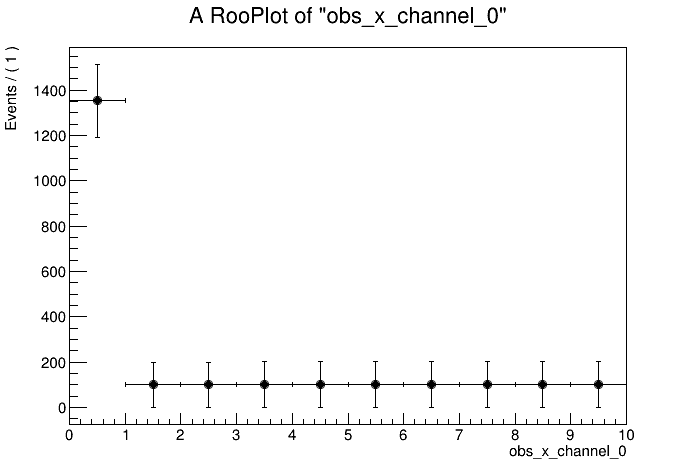

In [25]:
c = ROOT.TCanvas()
xframe = x.frame()
data.plotOn(xframe)
xframe.Draw()
c.Draw()

## Modularize it!

In [26]:
from TableBuilder import Model

In [27]:
m = Model()
nps = gen_nps(5)
m.add_nuisance_pars(nps)
m.add_channel(10)
m.add_channel(100)
m.add_channel(1)
m.add_sample([0,2],[10,500],signal=True,shape='linear',histosys=([1,3,4],[[0],[0,2],[0,2]]))
m.add_sample([0,1,2],[1000,500,10000],signal=False,shape='linear',histosys=[0,2,4])
m.add_sample([1,2],[750,5000],signal=False,shape='linear',histosys=([0,2,3],[[1],[1,2],[2]]))
m.Print()

+-----------+----------+--------+----------+---------+--------+--------+--------+--------+--------+
|  Channel  |  sample  | n bins | n events | signal? | nuis_0 | nuis_1 | nuis_2 | nuis_3 | nuis_4 |
+-----------+----------+--------+----------+---------+--------+--------+--------+--------+--------+
| channel_0 | sample_0 |   10   |    10    |   True  |        |   X    |        |   X    |   X    |
| channel_0 | sample_1 |   10   |   1000   |  False  |   X    |        |   X    |        |   X    |
| channel_1 | sample_1 |  100   |   500    |  False  |   X    |        |   X    |        |   X    |
| channel_1 | sample_2 |  100   |   750    |  False  |   X    |        |   X    |        |        |
| channel_2 | sample_0 |   1    |   500    |   True  |        |        |        |   X    |   X    |
| channel_2 | sample_1 |   1    |  10000   |  False  |   X    |        |   X    |        |   X    |
| channel_2 | sample_2 |   1    |   5000   |  False  |        |        |   X    |   X    |        |
